<a href="https://colab.research.google.com/github/VGGatGitHub/CohortProject_2020_week1/blob/master/Task1_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task #1 

A template code for training an RBM on H$_2$ data for $r = 1.2$ is shown here. Modify this!

Imports and loading in data:

In [1]:
! git clone https://github.com/VGGatGitHub/CohortProject_2020_week1.git

Cloning into 'CohortProject_2020_week1'...
remote: Enumerating objects: 723, done.
remote: Total 723 (delta 0), reused 0 (delta 0), pack-reused 723
Receiving objects: 100% (723/723), 19.37 MiB | 7.26 MiB/s, done.
Resolving deltas: 100% (393/393), done.


In [2]:
!pwd
!ls
f_loc="/content/CohortProject_2020_week1/Project_1_RBM_and_Tomography/"

/content
CohortProject_2020_week1  sample_data


In [3]:
import sys
sys.path.append(f_loc)

import os
print(os.getcwd())

r_list=[]
for dirname, _, filenames in os.walk(f_loc+"./H2_data/"):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        i1=filename.find("R_")
        i2=filename.find("_s")
        if i2-i1>2:
          #print(os.path.join(filename))
          r_list.append(filename[i1+2:i2])

/content


In [4]:
r_list

['1.3',
 '2.3',
 '2.25',
 '0.65',
 '1.85',
 '2.6',
 '1.55',
 '1.75',
 '1.65',
 '1.1',
 '2.4',
 '1.6',
 '1.15',
 '0.6',
 '2.7',
 '0.7',
 '1.45',
 '1.9',
 '2.05',
 '1.8',
 '2.1',
 '1.7',
 '2.5',
 '0.5',
 '2.15',
 '2.75',
 '2.45',
 '2.85',
 '0.45',
 '1.95',
 '0.85',
 '1.0',
 '1.2',
 '2.8',
 '2.35',
 '0.55',
 '0.35',
 '0.2',
 '0.25',
 '1.5',
 '0.3',
 '0.8',
 '1.4',
 '2.2',
 '1.05',
 '2.55',
 '0.95',
 '2.0',
 '0.9',
 '1.35',
 '0.75',
 '0.4',
 '1.25',
 '2.65']

In [5]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from RBM_helper import RBM

import H2_energy_calculator


In [6]:
coefficients = np.loadtxt(f_loc+"H2_data/H2_coefficients.txt")
coeff=coefficients[20,:]
r=coeff[0]

training_data = torch.from_numpy(np.loadtxt(f_loc+"H2_data/R_"+str(r)+"_samples.txt"))
true_energy = H2_energy_calculator.energy_from_freq(training_data, coeff)
print("H2 energy for r = ",r," :",true_energy)

H2 energy for r =  1.2  : -1.0642022250418146


In [7]:
len(r_list)

54

In [8]:
len(coefficients)

54

In [9]:
coeff


array([ 1.2   , -0.1253,  0.2374, -0.1603,  0.4892,  0.105 ,  0.105 ,
        5.9509])

In [10]:
training_data.detach().numpy().shape

(10000, 2)

Define the RBM:

In [11]:
rs=[]
for i in range(len(coefficients)):
  coeff=coefficients[i,:]
  r=coeff[0]
  rs.append(r)

In [12]:
n_vis = 2
n_hin = 10

rbm = RBM(n_vis, n_hin)

Train the RBM:

In [13]:
epochs = 500 # number of training steps
num_samples = 1000 # number of samples to generate from the RBM to calculate the H2 energy
printing=100 # when to print intermidiate results

rs=[]
true_energies=[]
computed_Es=[]
cmpted_Es=np.empty((epochs//printing,len(coefficients)))

for i in range(len(coefficients)-1,-1,-1):
  coeff=coefficients[i,:]
  r=coeff[0]
  rs.append(r)
  #rbm = RBM(n_vis, n_hin)

  training_data = torch.from_numpy(np.loadtxt(f_loc+"H2_data/R_"+str(r)+"_samples.txt"))
  true_energy = H2_energy_calculator.energy_from_freq(training_data, coeff)

  true_energies.append(true_energy)
  #print("H2 energy for r =\t",r,"\t:",true_energy)

  for e in range(1, epochs+1):
      # do one epoch of training
      rbm.train(training_data)   
  
      # now generate samples and calculate the energy
      if e % printing == 0:
          #print("\nEpoch: ", e)
          #print("Sampling the RBM...")

          # For sampling the RBM, we need to do Gibbs sampling.
          # Initialize the Gibbs sampling chain with init_state as defined below.
          init_state = torch.zeros(num_samples, n_vis)
          RBM_samples = rbm.draw_samples(15, init_state)

          #print("Done sampling. Calculating energy...")       
  
          energies = H2_energy_calculator.energy(RBM_samples, coeff, rbm.wavefunction)
          #print("Energy from RBM samples: ", energies.item())
  
          cmpted_Es[e//printing-1,i]=energies.item()
      
      init_state = torch.zeros(num_samples, n_vis)
      RBM_samples = rbm.draw_samples(15, init_state)
      energies = H2_energy_calculator.energy(RBM_samples, coeff, rbm.wavefunction)
      RBM_energy = energies.item()
      if 100*abs(1-RBM_energy/true_energy) < 1.0:
        break
  
  energies = H2_energy_calculator.energy(RBM_samples, coeff, rbm.wavefunction)
  RBM_energy = energies.item()
  computed_Es.append(RBM_energy)
  print("H2 energy for r ={:6.3f}, E={:7.3f}, E_rmb={:7.3f}, diff:{:5.1f}%".format(
      r,true_energy,RBM_energy,100*abs(1-RBM_energy/true_energy)))


H2 energy for r = 2.850, E= -0.943, E_rmb= -0.936, diff:  0.7%
H2 energy for r = 2.800, E= -0.943, E_rmb= -0.937, diff:  0.7%
H2 energy for r = 2.750, E= -0.943, E_rmb= -0.937, diff:  0.6%
H2 energy for r = 2.700, E= -0.944, E_rmb= -0.935, diff:  0.9%
H2 energy for r = 2.650, E= -0.944, E_rmb= -0.936, diff:  0.9%
H2 energy for r = 2.600, E= -0.944, E_rmb= -0.939, diff:  0.6%
H2 energy for r = 2.550, E= -0.945, E_rmb= -0.935, diff:  1.0%
H2 energy for r = 2.500, E= -0.945, E_rmb= -0.937, diff:  0.8%
H2 energy for r = 2.450, E= -0.945, E_rmb= -0.939, diff:  0.7%
H2 energy for r = 2.400, E= -0.946, E_rmb= -0.937, diff:  0.9%
H2 energy for r = 2.350, E= -0.947, E_rmb= -0.940, diff:  0.7%
H2 energy for r = 2.300, E= -0.948, E_rmb= -0.942, diff:  0.6%
H2 energy for r = 2.250, E= -0.949, E_rmb= -0.940, diff:  1.0%
H2 energy for r = 2.200, E= -0.950, E_rmb= -0.942, diff:  0.9%
H2 energy for r = 2.150, E= -0.952, E_rmb= -0.945, diff:  0.7%
H2 energy for r = 2.100, E= -0.953, E_rmb= -0.948, diff

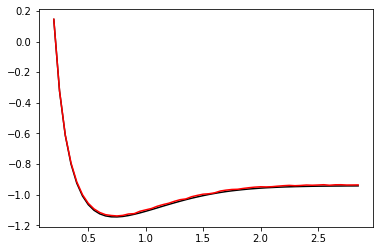

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
#plt.xlim(-2, 2)
#plt.ylim(0, 1.1)
plt.plot(rs, true_energies,'k')
plt.plot(rs, computed_Es,'r')

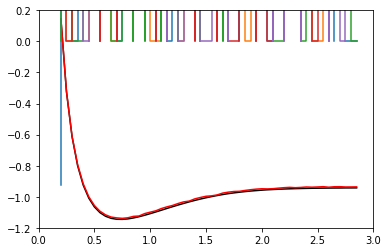

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.xlim(0, 3)
plt.ylim(-1.2, 0.2)
plt.plot(rs, true_energies,'k')
plt.plot(rs, computed_Es,'r')
for i in range(epochs//printing):
  plt.plot(rs, cmpted_Es[i,:])